# LSTM time series models

Reference:
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Dataset:
https://data.gov.sg/dataset/rainfall-monthly-number-of-rain-days

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, CuDNNLSTM, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import time

sns.set_style('whitegrid')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# check if we are using GPU
from keras import backend
has_gpu = len(backend.tensorflow_backend._get_available_gpus()) > 0
has_gpu

True

In [3]:
df = pd.read_csv('./rainfall-monthly-number-of-rain-days/rainfall-monthly-number-of-rain-days.csv', parse_dates=True, index_col=0)
df.head()

,no_of_rainy_days
month,
1982-01-01,10
1982-02-01,5
1982-03-01,11
1982-04-01,14
1982-05-01,10


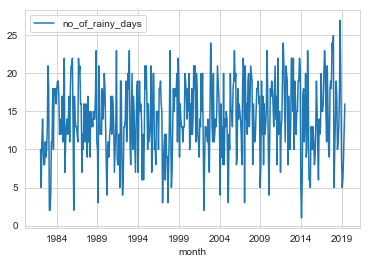

In [4]:
df.plot()
plt.show()

## Data Preparation

- Check for stationarity
- Min-max Scaling for easier convergence
- Performing windowing to split a sequence into columns.

In [5]:
# Check for stationairty. pvalue > 0.05 means the series is NOT stationary (has unit root)

adfuller(df['no_of_rainy_days'])

(-5.218980389060624,
 8.04058686110119e-06,
 14,
 435,
 {'1%': -3.4454725477848998,
  '5%': -2.8682072297316794,
  '10%': -2.570321396485665},
 2525.406354972463)

8.04058686110119e-06 is much less than 0.05, so this series is considered "stationary". We don't need to do differencing or decompose to remove seasonality.

In [6]:
# Min-max Scaling for easier convergence
scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df)
df.head()

C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,no_of_rainy_days,scaled
month,,
1982-01-01,10,0.346154
1982-02-01,5,0.153846
1982-03-01,11,0.384615
1982-04-01,14,0.500000
1982-05-01,10,0.346154


In [7]:
# Windowing to split a sequence into columns.
window_size = 7

shifted = [df['scaled'].shift(-i) for i in range(window_size)]
df_windowed = pd.concat(shifted, axis=1).dropna()
df_windowed.columns = [f'y[t+{i}]' for i in range(window_size)]
df_windowed.head()

,y[t+0],y[t+1],y[t+2],y[t+3],y[t+4],y[t+5],y[t+6]
month,,,,,,,
1982-01-01,0.346154,0.153846,0.384615,0.500000,0.346154,0.269231,0.269231
1982-02-01,0.153846,0.384615,0.500000,0.346154,0.269231,0.269231,0.384615
1982-03-01,0.384615,0.500000,0.346154,0.269231,0.269231,0.384615,0.307692
1982-04-01,0.500000,0.346154,0.269231,0.269231,0.384615,0.307692,0.346154
1982-05-01,0.346154,0.269231,0.269231,0.384615,0.307692,0.346154,0.461538


## Select X and y

- X: all columns except last column
- y: last column
- Reshape to train for RNN
- Train test split without shuffling (to preserve ordering)

In [8]:
# .values returns the numpy array for easier manipulation

# X: all columns except last column
X = df_windowed.iloc[:, :-1].values

# y: last column
y = df_windowed.iloc[:, -1].values

In [9]:
X.shape, y.shape

((444, 6), (444,))

In [10]:
# Reshape to train for RNN

n_steps = window_size-1
n_features = 1

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_rnn = X.reshape(X.shape[0], X.shape[1], n_features)

In [11]:
X_rnn.shape

(444, 6, 1)

In [12]:
# train test split without shuffling (to preserve ordering)
X_train, X_test, y_train, y_test = train_test_split(X_rnn, y, test_size=0.2, shuffle=False)

In [13]:
X_train.shape, X_test.shape

((355, 6, 1), (89, 6, 1))

In [14]:
X_train

array([[[0.34615385],
        [0.15384615],
        [0.38461538],
        [0.5       ],
        [0.34615385],
        [0.26923077]],

       [[0.15384615],
        [0.38461538],
        [0.5       ],
        [0.34615385],
        [0.26923077],
        [0.26923077]],

       [[0.38461538],
        [0.5       ],
        [0.34615385],
        [0.26923077],
        [0.26923077],
        [0.38461538]],

       ...,

       [[0.53846154],
        [0.53846154],
        [0.23076923],
        [0.46153846],
        [0.5       ],
        [0.73076923]],

       [[0.53846154],
        [0.23076923],
        [0.46153846],
        [0.5       ],
        [0.73076923],
        [0.88461538]],

       [[0.23076923],
        [0.46153846],
        [0.5       ],
        [0.73076923],
        [0.88461538],
        [0.76923077]]])

## Vanilla LSTM

Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

Since we are passing in multiple timesteps and 1 feature, we don't have to set stateful=True for LSTM to save state across batches. (The default batch size is 32)

In [15]:
# define model
model = Sequential()

if has_gpu:
    # if have GPU, use the GPU version of LSTM
    model.add(CuDNNLSTM(100, input_shape=(n_steps, n_features)))
    model.add(Activation(activation='relu')) # CuDNNLSTM does not include activation, so add an Activation layer
else:
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               41200     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [16]:
mc = ModelCheckpoint('./vanilla_lstm.h5', save_best_only=True)
es = EarlyStopping(patience=5)
tb = TensorBoard(log_dir=f'./logs/vanilla_lstm/{int(time.time())}/')

In [17]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[mc, tb, es])

Train on 355 samples, validate on 89 samples
Epoch 1/200
355/355 [==============================] - 1s 4ms/step - loss: 0.1530 - val_loss: 0.0585
Epoch 2/200
355/355 [==============================] - 0s 160us/step - loss: 0.0413 - val_loss: 0.0503
Epoch 3/200
355/355 [==============================] - 0s 147us/step - loss: 0.0357 - val_loss: 0.0480
Epoch 4/200
355/355 [==============================] - 0s 208us/step - loss: 0.0352 - val_loss: 0.0482
Epoch 5/200
355/355 [==============================] - 0s 160us/step - loss: 0.0351 - val_loss: 0.0471
Epoch 6/200
355/355 [==============================] - 0s 188us/step - loss: 0.0353 - val_loss: 0.0470
Epoch 7/200
355/355 [==============================] - 0s 132us/step - loss: 0.0341 - val_loss: 0.0466
Epoch 8/200
355/355 [==============================] - 0s 171us/step - loss: 0.0342 - val_loss: 0.0464
Epoch 9/200
355/355 [==============================] - 0s 180us/step - loss: 0.0341 - val_loss: 0.0464
Epoch 10/200
355/355 [========

355/355 [==============================] - 0s 196us/step - loss: 0.0329 - val_loss: 0.0422
Epoch 80/200
355/355 [==============================] - 0s 124us/step - loss: 0.0338 - val_loss: 0.0394
Epoch 81/200
355/355 [==============================] - 0s 185us/step - loss: 0.0319 - val_loss: 0.0401
Epoch 82/200
355/355 [==============================] - 0s 124us/step - loss: 0.0311 - val_loss: 0.0397
Epoch 83/200
355/355 [==============================] - 0s 126us/step - loss: 0.0317 - val_loss: 0.0398


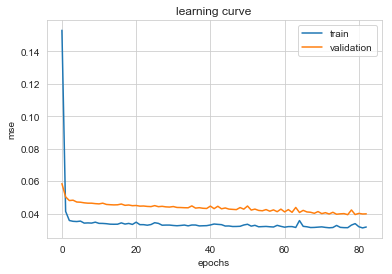

In [18]:
# plot the learning curve
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='validation')
ax.set_title('learning curve')
ax.set_xlabel('epochs')
ax.set_ylabel('mse')
ax.legend()
plt.show()

### Predict

In [19]:
best_model = load_model('./vanilla_lstm.h5')
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               41200     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [20]:
# last 5 values of the test set
test, testy = X_test[:-5], y_test[:-5]
test, testy

(array([[[0.46153846],
         [0.5       ],
         [0.73076923],
         [0.88461538],
         [0.76923077],
         [0.57692308]],
 
        [[0.5       ],
         [0.73076923],
         [0.88461538],
         [0.76923077],
         [0.57692308],
         [0.38461538]],
 
        [[0.73076923],
         [0.88461538],
         [0.76923077],
         [0.57692308],
         [0.38461538],
         [0.76923077]],
 
        [[0.88461538],
         [0.76923077],
         [0.57692308],
         [0.38461538],
         [0.76923077],
         [0.73076923]],
 
        [[0.76923077],
         [0.57692308],
         [0.38461538],
         [0.76923077],
         [0.73076923],
         [0.69230769]],
 
        [[0.57692308],
         [0.38461538],
         [0.76923077],
         [0.73076923],
         [0.69230769],
         [0.26923077]],
 
        [[0.38461538],
         [0.76923077],
         [0.73076923],
         [0.69230769],
         [0.26923077],
         [0.61538462]],
 
        [[0.7

In [21]:
pred = best_model.predict(test) # since this LSTM is not stateful, no need to fast-forward

mean_squared_error(testy, pred), r2_score(testy, pred)

(0.03953388736326807, 0.11626698920700929)

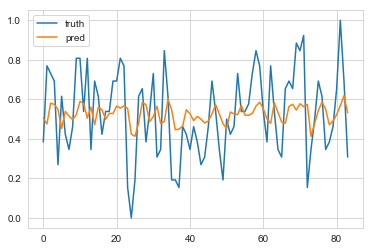

In [22]:
fig, ax = plt.subplots()
ax.plot(testy, label='truth')
ax.plot(pred, label='pred')
ax.legend()
plt.show()

## Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [23]:
# define model
model = Sequential()

if has_gpu:
    model.add(CuDNNLSTM(100, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Activation(activation='relu'))
    model.add(CuDNNLSTM(100))
    model.add(Activation(activation='relu'))
else:
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 6, 100)            41200     
_________________________________________________________________
activation_2 (Activation)    (None, 6, 100)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________


In [24]:
mc = ModelCheckpoint('./stacked_lstm.h5', save_best_only=True)
es = EarlyStopping(patience=5)
tb = TensorBoard(log_dir=f'./logs/stacked_lstm/{int(time.time())}/')

In [25]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[mc, tb, es])

Train on 355 samples, validate on 89 samples
Epoch 1/200
355/355 [==============================] - 0s 1ms/step - loss: 0.1752 - val_loss: 0.0516
Epoch 2/200
355/355 [==============================] - 0s 259us/step - loss: 0.0464 - val_loss: 0.0519
Epoch 3/200
355/355 [==============================] - 0s 231us/step - loss: 0.0386 - val_loss: 0.0474
Epoch 4/200
355/355 [==============================] - 0s 259us/step - loss: 0.0352 - val_loss: 0.0474
Epoch 5/200
355/355 [==============================] - 0s 183us/step - loss: 0.0342 - val_loss: 0.0470
Epoch 6/200
355/355 [==============================] - 0s 194us/step - loss: 0.0341 - val_loss: 0.0468
Epoch 7/200
355/355 [==============================] - 0s 188us/step - loss: 0.0345 - val_loss: 0.0468
Epoch 8/200
355/355 [==============================] - 0s 177us/step - loss: 0.0339 - val_loss: 0.0466
Epoch 9/200
355/355 [==============================] - 0s 219us/step - loss: 0.0339 - val_loss: 0.0465
Epoch 10/200
355/355 [========

355/355 [==============================] - 0s 180us/step - loss: 0.0315 - val_loss: 0.0397
Epoch 80/200
355/355 [==============================] - 0s 177us/step - loss: 0.0347 - val_loss: 0.0428
Epoch 81/200
355/355 [==============================] - 0s 180us/step - loss: 0.0315 - val_loss: 0.0401


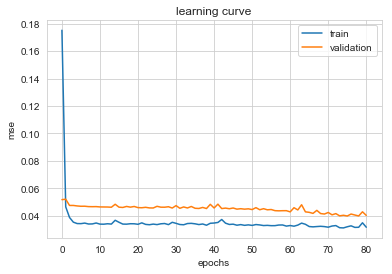

In [26]:
# plot the learning curve
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='validation')
ax.set_title('learning curve')
ax.set_xlabel('epochs')
ax.set_ylabel('mse')
ax.legend()
plt.show()

### Predict

In [27]:
best_model = load_model('./stacked_lstm.h5')
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 6, 100)            41200     
_________________________________________________________________
activation_2 (Activation)    (None, 6, 100)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________


In [28]:
pred_stacked = best_model.predict(test) # since this LSTM is not stateful, no need to fast-forward

mean_squared_error(testy, pred_stacked), r2_score(testy, pred_stacked)

(0.04024500847001979, 0.1003707230257066)

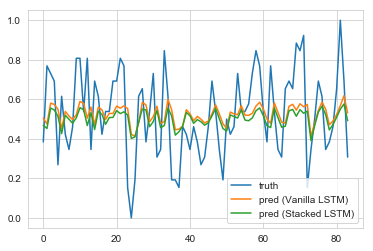

In [29]:
fig, ax = plt.subplots()
ax.plot(testy, label='truth')
ax.plot(pred, label='pred (Vanilla LSTM)')
ax.plot(pred_stacked, label='pred (Stacked LSTM)')
ax.legend()
plt.show()

### Observations

Both Vanilla and Stack LSTM predict more "averaged" results. The averaging seems to get worse with Stacked LSTM (we are passing through deeper layers). 

Possible experiments:
- Reduce the timesteps so that we are only looking at shorter term fluctuations (last 1-2 months).
- Try a wider LSTM (more units) rather than a deeper one to learn the patterns. There doesn't seem to be much pattern...
- Try a Conv LSTM. Although Conv probably will result in more temporal averaging as well.
- Try ARIMA to see if statistical method can perform better.